
## Машинное обучение 2
### Семинар 5. Модели внимания, трансформеры

<br />
<br />
18 марта 2022

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/14c9NH-fHmK5Lh7ftjH53cXXDuRMFerLV?usp=sharing)

Источник вдохновения тот же: https://github.com/andriygav/MachineLearningSeminars/blob/master/sem18/

Видео семинара МФТИ https://www.youtube.com/watch?v=GfUadGOcwtc

Ссылка на этот ноутбук (запускать в colab):
https://colab.research.google.com/drive/14c9NH-fHmK5Lh7ftjH53cXXDuRMFerLV?usp=sharing

## Библиотеки

In [1]:
!pip install -U dvc[gdrive]==1.11.1 transformers==4.5.1 sentencepiece

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import gridspec

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import scipy
from transformers import AutoModel, AutoTokenizer
from transformers import MarianMTModel, MarianTokenizer

from sklearn.metrics import classification_report
from torch.utils.tensorboard import SummaryWriter

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Выборка паралельных текстов

In [5]:
!dvc get https://github.com/andriygav/MachineLearningSeminars sem18/data/Wikipedia.en-ru.ru
!dvc get https://github.com/andriygav/MachineLearningSeminars sem18/data/Wikipedia.en-ru.en

  0% 0/1 [00:00<?, ?file/s{'info': ''}]Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?client_id=710796635688-iivsgbgsb6uv1fap6635dhvuei09o66c.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.appdata&access_type=offline&response_type=code&approval_prompt=force

Enter verification code: 4/1AX4XfWgisp2DN5eha1hTzxX4WdYs75Pv5AX4Iz4BihnmnORxAn62wAHJNp4
Authentication successful.
Downloading:   0% 0/1 [00:00<?, ?file/s{'info': ''}]
!
  0% sem18/data/Wikipedia.en-ru.ru|          |0.00/? [00:00<?,        ?B/s]
100% 92.2M/92.2M [00:03<00:00, 29.0MB/s{'info': ''}]                       
  0% 0/1 [00:00<?, ?file/s{'info': ''}]Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?client_id=710796635688-iivsgbgsb6uv1fap6635dhvuei09o66c.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoaut

In [6]:
with open('./Wikipedia.en-ru.ru') as f:
    ru_all_texts = f.read().splitlines()

with open('./Wikipedia.en-ru.en') as f:
    en_all_texts = f.read().splitlines()

In [7]:
ru_texts = []
en_texts = []

for ru_text, en_text in zip(ru_all_texts, en_all_texts):
    if len(ru_text) < 100 and len(en_text) < 100:
        ru_texts.append(ru_text.lower())
        en_texts.append(en_text.lower())

In [8]:
ru_texts[:5]

['через неделю, 1 сентября, германия начала вторжение в польшу.',
 '29 марта 2004 года литва вступила в нато.',
 'число занятых в промышленности — 27,5 % трудоспособного населения.',
 'традиционно в россии популярны настольные интеллектуальные игры.',
 'о статусе соционики существуют противоположные мнения.']

In [9]:
en_texts[:5]

['average temperatures on the coast are in january and in july.',
 'in march 2004, lithuania became a full member of the nato.',
 '73% of the population lives in urban areas while 27% in rural ones.',
 'association football is one of the most popular sports in modern russia.',
 'a. augustinavichiute and sources of socionics.']

In [10]:
len(ru_texts), len(en_texts)

(306887, 306887)

## Код для обучения

In [11]:
def train_on_batch(model, x_batch, y_batch, optimizer, loss_function):
    model.train()
    optimizer.zero_grad()
    
    # модель принимает правильные ответы
    output = model(x_batch.to(model.device), y_batch.to(model.device))
    
    loss = loss_function(output.transpose(1,2), 
                         y_batch.to(model.device))
    loss.backward()

    optimizer.step()
    return loss.cpu().item()

In [12]:
def train_epoch(train_generator, model, loss_function, optimizer, callback = None):
    epoch_loss = 0
    total = 0
    for it, (batch_of_x, batch_of_y) in enumerate(train_generator):
        batch_loss = train_on_batch(model, batch_of_x, batch_of_y, optimizer, loss_function)
        
        if callback is not None:
            with torch.no_grad():
                callback(model, batch_loss)
            
        epoch_loss += batch_loss*len(batch_of_x)
        total += len(batch_of_x)
    
    return epoch_loss/total

In [13]:
def trainer(count_of_epoch, 
            batch_size, 
            dataset,
            model, 
            loss_function,
            optimizer,
            lr = 0.001,
            callback = None):

    optima = optimizer(model.parameters(), lr=lr)
    
    iterations = tqdm(range(count_of_epoch), desc='epoch')
    iterations.set_postfix({'train epoch loss': np.nan})
    for it in iterations:
        batch_generator = tqdm(
            torch.utils.data.DataLoader(dataset=dataset, 
                                        batch_size=batch_size, 
                                        shuffle=True, pin_memory=True), 
            leave=False, total=len(dataset)//batch_size+(len(dataset)%batch_size>0))
        
        epoch_loss = train_epoch(train_generator=batch_generator, 
                    model=model, 
                    loss_function=loss_function, 
                    optimizer=optima, 
                    callback=callback)
        
        iterations.set_postfix({'train epoch loss': epoch_loss})

## Модель внимания в рекурентных моделях

### Определение модели

In [14]:
class Encoder(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, vocab_size, emb_dim=30, hidden_dim=30):
        super(Encoder, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size, emb_dim)
        self.lstm = torch.nn.LSTM(emb_dim, hidden_dim, batch_first=True)

    def forward(self, input):
        r'''
        :param input: тензор размера batch_size x seq_len --- список токенов

        '''
        act = self.embedding(input)
        act, hidden = self.lstm(act)
        # дополнительно возвращаем все эмбединги входных токенов
        return act, hidden

In [15]:
class Decoder(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, vocab_size, emb_dim=30, hidden_dim=30):
        super(Decoder, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size, emb_dim)
        self.attention = torch.nn.MultiheadAttention(emb_dim, 1)

        self.lstm = torch.nn.LSTM(emb_dim, hidden_dim, batch_first=True)

        self.linear = torch.nn.Linear(hidden_dim, vocab_size)

    def forward(self, input, encoder_outputs, hidden):
        r'''
        :param input: тезор размера batch_size x seq_len
        '''
        act = self.embedding(input)

        act, _ = self.attention(act.transpose(0, 1), 
                                encoder_outputs.transpose(0, 1), 
                                encoder_outputs.transpose(0, 1))

        act = act.transpose(0, 1)
        act, hidden = self.lstm(act, hidden)
        # возвращаем hidden, чтобы по одному выходные токены генерировать
        return self.linear(act), hidden

In [16]:
class seq2seq(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, vocab_size, emb_dim=30, hidden_dim=30):
        super(seq2seq, self).__init__()
        self.vocab_size = vocab_size
        self.encoder = Encoder(vocab_size, emb_dim, hidden_dim)
        self.decoder = Decoder(vocab_size, emb_dim, hidden_dim)

    def forward(self, input, decoder_input=None, max_seq_len=64):
        r'''
        '''
        encoder_output, hidden = self.encoder(input)

        if decoder_input is None:
            translated_scores = torch.zeros(len(input), 
                                            max_seq_len, 
                                            self.vocab_size).to(self.device)
            translated_scores[:, 0, input[:, 0]] = 1.
            for i in range(1, max_seq_len):
                translated_scores[:, i:i+1], hidden = self.decoder(
                    torch.argmax(translated_scores[:, i-1:i], axis=-1), 
                    encoder_output, 
                    hidden)
        else:
            translated_scores, _ = self.decoder(
                decoder_input, encoder_output, hidden)

        return translated_scores


### Инициализация модели

In [17]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-uncased', 
                                          verbose=False)
tokenizer.vocab_size

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/872k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

105879

In [18]:
en_texts_tensors = tokenizer(en_texts[:20000], 
                             return_tensors='pt', max_length=64, padding=True)
ru_texts_tensors = tokenizer(ru_texts[:20000], 
                             return_tensors='pt', max_length=64, padding=True)

In [19]:
# actually not ok to include whole dataset in memory, better to write batch_generator
dataset_train_pt = torch.utils.data.TensorDataset(
    en_texts_tensors['input_ids'][:19000], ru_texts_tensors['input_ids'][:19000])
dataset_test_pt = torch.utils.data.TensorDataset(
    en_texts_tensors['input_ids'][19000:], ru_texts_tensors['input_ids'][19000:])

In [20]:
model = seq2seq(tokenizer.vocab_size)
model.to(device)

seq2seq(
  (encoder): Encoder(
    (embedding): Embedding(105879, 30)
    (lstm): LSTM(30, 30, batch_first=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(105879, 30)
    (attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=30, out_features=30, bias=True)
    )
    (lstm): LSTM(30, 30, batch_first=True)
    (linear): Linear(in_features=30, out_features=105879, bias=True)
  )
)

In [21]:
loss_function = torch.nn.CrossEntropyLoss(ignore_index=0) # to ignore <PAD>
optimizer = torch.optim.Adam

In [22]:
trainer(count_of_epoch=5, 
        batch_size=64, 
        dataset=dataset_train_pt,
        model=model, 
        loss_function=loss_function,
        optimizer = optimizer,
        lr=0.001,
        callback=None)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/297 [00:00<?, ?it/s]

  0%|          | 0/297 [00:00<?, ?it/s]

  0%|          | 0/297 [00:00<?, ?it/s]

  0%|          | 0/297 [00:00<?, ?it/s]

  0%|          | 0/297 [00:00<?, ?it/s]

In [23]:
tokens_en = tokenizer(['in 1924, most of the site was converted to a museum.'], return_tensors='pt')
tokens_ru = tokenizer(['в 1924 году крепость стала музеем.'], return_tensors='pt')
with torch.no_grad():
    answer = torch.argmax(
        model(tokens_en['input_ids'].to(model.device), 
              tokens_ru['input_ids'].to(model.device), max_seq_len=10), 
        axis=-1)
tokenizer.decode(answer[0])

'. [SEP] со [SEP] [CLS] со [CLS] [SEP] [SEP] [SEP]'

### Как вывести матрицу внимания?

In [24]:
with torch.no_grad():
    encoder_outputs, _ = model.encoder(
        tokens_en['input_ids'].to(model.device))

    decoder_embedding = model.decoder.embedding(
        tokens_ru['input_ids'].to(model.device))

    act, act_weight = model.decoder.attention(
        decoder_embedding.transpose(0, 1), 
        encoder_outputs.transpose(0, 1), 
        encoder_outputs.transpose(0, 1))

In [25]:
attention_frame = pd.DataFrame(
    act_weight[0].cpu().numpy(),
    index=tokenizer.convert_ids_to_tokens(
        tokens_ru['input_ids'][0].cpu().numpy()),
    columns=tokenizer.convert_ids_to_tokens(
        tokens_en['input_ids'][0].cpu().numpy()))

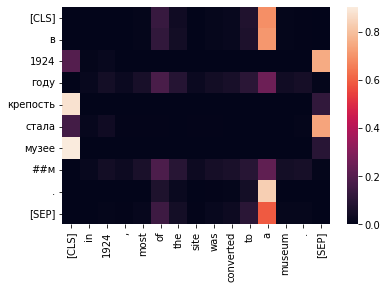

In [26]:
sns.heatmap(data=attention_frame)

plt.show()

## Трансформер 

### Определение модели

In [27]:
class Encoder(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, vocab_size, emb_dim=30, hidden_dim=30):
        super(Encoder, self).__init__()

        self.layers = torch.nn.Sequential()
        
        self.embedding = torch.nn.Embedding(vocab_size, emb_dim)
        self.attention1 = torch.nn.MultiheadAttention(emb_dim, 1)
        self.linear1 = torch.nn.Linear(emb_dim, hidden_dim)
        self.relu = torch.nn.ReLU()
        self.attention2 = torch.nn.MultiheadAttention(hidden_dim, 1)
        self.linear2 = torch.nn.Linear(hidden_dim, hidden_dim)


    def forward(self, input):
        r'''
        :param input: тензор размера batch_size x seq_len --- список токенов

        '''
        input = input.transpose(0, 1)
        act = self.embedding(input)
        act, _ = self.attention1(act, act, act)
        act = self.relu(act)
        act = self.linear1(act)
        act = self.relu(act)
        act, _ = self.attention2(act, act, act)
        act = self.relu(act)
        act = self.linear2(act)
        return act.transpose(0, 1)

In [28]:
class Decoder(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, vocab_size, emb_dim=30, hidden_dim=30):
        super(Decoder, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size, emb_dim)
        self.attention1 = torch.nn.MultiheadAttention(emb_dim, 1)
        self.linear1 = torch.nn.Linear(emb_dim, hidden_dim)
        self.relu = torch.nn.ReLU()

        self.attention2 = torch.nn.MultiheadAttention(hidden_dim, 1)
        self.linear2 = torch.nn.Linear(hidden_dim, hidden_dim)

        self.linear = torch.nn.Linear(hidden_dim, vocab_size)

    def forward(self, input, encoder_outputs):
        r'''
        :param input: тезор размера batch_size x seq_len
        '''
        input = input.transpose(0, 1)
        act = self.embedding(input)

        act, _ = self.attention1(act, 
                                encoder_outputs.transpose(0, 1), 
                                encoder_outputs.transpose(0, 1))
        
        act = self.relu(act)
        act = self.linear1(act)
        act = self.relu(act)
        act, _ = self.attention2(act, 
                                 encoder_outputs.transpose(0, 1), 
                                 encoder_outputs.transpose(0, 1))
        act = self.relu(act)
        act = self.linear2(act)

        return self.linear(act).transpose(0, 1)

In [29]:
class seq2seq(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, vocab_size, emb_dim=30, hidden_dim=30):
        super(seq2seq, self).__init__()
        self.vocab_size = vocab_size
        self.encoder = Encoder(vocab_size, emb_dim, hidden_dim)
        self.decoder = Decoder(vocab_size, emb_dim, hidden_dim)

    def forward(self, input, decoder_input=None, max_seq_len=64):
        r'''
        '''
        encoder_output = self.encoder(input)

        if decoder_input is None:
            translated_scores = torch.zeros(len(input), 
                                            max_seq_len, 
                                            self.vocab_size).to(self.device)
            translated_scores[:, 0, input[:, 0]] = 1.
            for i in range(1, max_seq_len):
                translated_scores[:, i:i+1] = self.decoder(
                    torch.argmax(translated_scores, axis=-1), 
                    encoder_output)[:, i:i+1]
        else:
            translated_scores = self.decoder(
                decoder_input, encoder_output)

        return translated_scores


### Инициализация модели

In [30]:
model = seq2seq(tokenizer.vocab_size)
model.to(device)

seq2seq(
  (encoder): Encoder(
    (layers): Sequential()
    (embedding): Embedding(105879, 30)
    (attention1): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=30, out_features=30, bias=True)
    )
    (linear1): Linear(in_features=30, out_features=30, bias=True)
    (relu): ReLU()
    (attention2): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=30, out_features=30, bias=True)
    )
    (linear2): Linear(in_features=30, out_features=30, bias=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(105879, 30)
    (attention1): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=30, out_features=30, bias=True)
    )
    (linear1): Linear(in_features=30, out_features=30, bias=True)
    (relu): ReLU()
    (attention2): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=30, out_features=30, bias=True)
    )
    (linear2): Linear(in_features=30, out_features

In [31]:
tokens_en = tokenizer(['in 1924, most of the site was converted to a museum.'], return_tensors='pt')
tokens_ru = tokenizer(['в 1924 году крепость стала музеем.'], return_tensors='pt')
with torch.no_grad():
    answer = torch.argmax(
        model(tokens_en['input_ids'].to(model.device), 
              tokens_ru['input_ids'].to(model.device)), 
        axis=-1)
tokenizer.decode(answer[0])

'attiva attiva attiva attiva attiva attiva attiva attiva attiva attiva'

In [32]:
loss_function = torch.nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam

In [33]:
trainer(count_of_epoch=5, 
        batch_size=64, 
        dataset=dataset_train_pt,
        model=model, 
        loss_function=loss_function,
        optimizer = optimizer,
        lr=0.001,
        callback=None)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/297 [00:00<?, ?it/s]

  0%|          | 0/297 [00:00<?, ?it/s]

  0%|          | 0/297 [00:00<?, ?it/s]

  0%|          | 0/297 [00:00<?, ?it/s]

  0%|          | 0/297 [00:00<?, ?it/s]

In [34]:
tokens_en = tokenizer(['in 1924, most of the site was converted to a museum.'], return_tensors='pt')
tokens_ru = tokenizer(['в 1924 году крепость стала музеем.'], return_tensors='pt')
with torch.no_grad():
    answer = torch.argmax(
        model(tokens_en['input_ids'].to(model.device), 
              tokens_ru['input_ids'].to(model.device)), 
        axis=-1)
tokenizer.decode(answer[0])

'к к к к к к к к к к'

## Переводчик Tensor2Tensor

In [35]:
tokenizer = MarianTokenizer.from_pretrained('Helsinki-NLP/opus-mt-ru-en')
model = MarianMTModel.from_pretrained('Helsinki-NLP/opus-mt-ru-en')
model.to(device)

Downloading:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/803k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.13k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/307M [00:00<?, ?B/s]

MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(62518, 512, padding_idx=62517)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(62518, 512, padding_idx=62517)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0): MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        )
   

In [36]:
batch_x = tokenizer.prepare_seq2seq_batch(src_texts=['Привет мир, меня зовут Трансформер'], return_tensors="pt")

In [37]:
tokenizer.batch_decode(model.generate(**batch_x.to(device)))

['<pad> Hey, world, my name is Transformer.']

## Токенизация BPE (Byte Pair Encoding)

In [38]:
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/LaBSE', 
                                          verbose=False)
tokenizer.vocab_size

Downloading:   0%|          | 0.00/804 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.22M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.62M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

501153

In [39]:
tokenizer.tokenize('Hello Mathematic, my Name is Alex, how are you?')

['Hello',
 'Math',
 '##emat',
 '##ic',
 ',',
 'my',
 'Name',
 'is',
 'Alex',
 ',',
 'how',
 'are',
 'you',
 '?']

## BERT (Bidirectional Encoder Representations from Transformers)

In [40]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased', 
                                          verbose=False)
model = AutoModel.from_pretrained('bert-base-multilingual-cased')
model.to(device)

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/714M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
         

### Архитектура BERT
Разделяется условно на три части:

- Tokens Embedding
- Self-Attention
- Pooler — сделать эмбеддинг всего предложения из эмбедингов токенов

### Математическая модель BERT
Пусть задано множество токенов:
$$
\mathcal{I} = \{\mathbf{i}| \mathbf{i} = [0, \cdots, 0, 1, 0,  \cdots, 0]^{\mathsf{T}}\}
$$

Задано множество предложений и множество типов токенов в предложении:
$$
\mathcal{S} = \mathcal{I}^n, \quad \mathcal{T} = \{[0,1]^{\mathsf{T}}, [1,0]^{\mathsf{T}}\}^n
$$

Отображения:
$$
BM_1: \mathbb{R}^{n\times L}\times \mathbb{R}^{n\times 2} \to \mathbb{R}^{n \times l}
$$ — эмбединги слов
$$
BM_2: \mathbb{R}^{n\times L}\times \mathbb{R}^{n\times 2} \to \mathbb{R}^{1 \times l}
$$ — эмбединг всего предложения

Суперпозиция отображений:
$$
BM_1 = BL_m \circ \cdots \circ BL_1 \circ BSE
$$
$$
BM_2 = BP \circ BL_m \circ \cdots \circ BL_1 \circ BSE
$$

### Математическая модель BERT: Bert sequence embedding (BSE)

Функция $BSE$:
$$
BSE:\mathbb{R}^{n\times L} \times \mathbb{R}^{n\times 2} \to \mathbb{R}^{n\times l}.
$$

Для произвольной матрицы $\mathbf{s} \in \mathcal{S} \subset \mathbb{R}^{n\times L}$ и матрицы $\mathbf{t} \in \mathcal{T}\subset \mathbb{R}^{n\times 2}$ отображение $BSE$ принимает следующий вид:
$$
BSE\bigr(\mathbf{s}, \mathbf{t}\bigr) = \frac{\mathbf{h}_{bse} - \mathsf{E}\mathbf{h}_{bse}}{\sqrt{\mathsf{D}\mathbf{h}_{bse}+\varepsilon}}\cdot\textbf{w}_1 + \textbf{w}_2, \quad \mathbf{h}_{bse} = \mathbf{s}\mathbf{W}_1 + \mathbf{1}_{n\times n}\mathbf{W}_2 + \mathbf{t}\mathbf{W}_3,
$$
где $\mathbf{W}_1 \in \mathbb{R}^{L\times l},~\mathbf{W}_2 \in \mathbb{R}^{n\times l},~\mathbf{W}_3 \in \mathbb{R}^{2\times l}.$

Функция $BSE$ имеет настриваемые параметры: $\mathbf{W}_1, \mathbf{W}_2, \mathbf{W}_3, \mathbf{w}_1, \mathbf{w}_2.$

Результат работы функции $BSE$ обозначим:
$$
\mathbf{h}_0 = BSE\bigr(\mathbf{s}, \mathbf{t}\bigr),
$$
где $\mathbf{h} \in \mathbb{R}^{n\times l}.$

### Математическая модель BERT: BertLayer (BL)

Функция $BL$:
$$
    BL: \mathbb{R}^{n\times l} \to \mathbb{R}^{n\times l}.
$$
Для матрицы $\mathbf{h} \in \mathbb{R}^{n\times l}$ BL принимает следующий вид:
$$
    BL_q\bigr(\mathbf{h}\bigr) = \frac{\mathbf{u}\mathbf{W}_{3+6q} + \mathbf{a} - \mathsf{E}\left(\mathbf{u}\mathbf{W}_{3+6q} + \mathbf{a}\right)}{\sqrt{\mathsf{D}\left(\mathbf{u}\mathbf{W}_{3+6q} + \mathbf{a}\right)+\varepsilon}}\cdot\textbf{w}_{3+4q} + \textbf{w}_{4+4q},
$$
$$
\mathbf{u} = \sigma\bigr(\mathbf{a}\mathbf{W}_{4+6q}\bigr), \quad \mathbf{a} = \frac{\mathbf{c}\mathbf{W}_{5+6q} - \mathsf{E}\mathbf{c}\mathbf{W}_{5+6q}}{\sqrt{\mathsf{D}\mathbf{c}\mathbf{W}_{5+6q}+\varepsilon}}\cdot\textbf{w}_{5+4q} + \textbf{w}_{6+4q}
$$
$$
\mathbf{c} = [\mathbf{c}_1, \cdots \mathbf{c}_{J}]
$$
$$
\mathbf{c}_j = \text{softmax}\bigr(\mathbf{h}\mathbf{W}^{j}_{6+6q}\odot\mathbf{h}\mathbf{W}^{j}_{7+6q}\bigr)\odot\mathbf{h}\mathbf{W}^{j}_{8+6q}
$$
где для всех $q$ матрицы $\mathbf{W}^{j}_{6+6q}, \mathbf{W}^{j}_{7+6q}, \mathbf{W}^{j}_{8+6q} \in \mathbb{R}^{l \times r}$, для всех $j$ матрицы $\mathbf{c}_j \in \mathbb{R}^{n\times r}$, для всех $q$ матрицы $\mathbf{W}^{j}_{5+6q} \in \mathbb{R}^{l \times l}, \mathbf{W}^{j}_{4+6q} \in \mathbb{R}^{l \times p}, \mathbf{W}^{j}_{3+6q} \in \mathbb{R}^{p \times l}$, матрица $\mathbf{c}, \mathbf{a} \in \mathbb{R}^{n \times l}$, матрица $\mathbf{u} \in \mathbb{R}^{n \times p}$.

$$ J \cdot r = l$$

Настраиваемые параметры: $\mathbf{W}^{j}_{3+6q}, \mathbf{W}^{j}_{4+6q}, \mathbf{W}^{j}_{5+6q}, \mathbf{W}^{j}_{6+6q}, \mathbf{W}^{j}_{7+6q}, \mathbf{W}^{j}_{8+6q}, \textbf{w}_{3+4q}, \textbf{w}_{4+4q}, \textbf{w}_{5+4q}, \textbf{w}_{6+4q}$

Результат работы функции $BL_q$:
$$
\forall q \in \{1, \dots, m\} \quad \mathbf{h}_{q} = BL_q\bigr(\mathbf{h}_{q-1}\bigr).
$$


### Математическая модель BERT: BertPooler (BP)

Функция $BP$:
$$
    BP: \mathbb{R}^{n\times l} \to \mathbb{R}^{n\times l}.
$$
Для матрицы $\mathbf{h}_{m} \in \mathbb{R}^{n \times l}$ BP принимает следующий вид:
$$
BP\bigr(\mathbf{h}_{m}\bigr) = \tanh\bigr(\mathbf{h}_m^{1}\mathbf{W}_{9+6m}\bigr),
$$
где $\mathbf{h}_m^{1}$ первая строка матрицы $\mathbf{h}_{m}$, а матрица $\mathbf{W}_{9+6m} \in \mathbb{R}^{l\times l}$

Функция $BP$ имеет настраиваемые параметры $\mathbf{W}_{9+6m}$

Результат работы функции $BP$:
$$
\mathbf{h} = BP\bigr(\mathbf{h}_m\bigr).
$$

### Снова суперпозиция

Вернемся к суперпозициям $BM_1, BM_2$:
$$
\mathbf{h} = BP\bigr(\mathbf{h}_m\bigr), \quad\mathbf{h}_q = BM\bigr(\mathbf{h}_{q-1} \bigr), \quad \mathbf{h}_0 = BSE\bigr(\mathbf{s}, \mathbf{t}\bigr)
$$

Получаем вектор эмбедингов слов:
$$
BM_1\bigr(\mathbf{s}, \mathbf{t}\bigr) = \mathbf{h}_m,
$$
Получаем вектор эмбединга предложения:
$$
BM_2\bigr(\mathbf{s}, \mathbf{t}\bigr) = \mathbf{h}
$$

### Multitask Learning

LM модель:
$$
\mathbf{v} = \text{softmax}\bigr(\mathbf{h}_m\mathbf{W}_{LM}\bigr),
$$
где $\mathbf{W}_{LM} \in \mathbb{R}^{l \times L}$, а $\mathbf{v}$ это вероятность каждого токена.

NSP модель:
$$
z = \sigma\bigr(\mathbf{h}\mathbf{W}_{NSP}\bigr),
$$
где $\mathbf{W}_{NSP} \in \mathbb{R}^{l \times 1}$, а $z$ это вероятность класса $1$.

Функция ошибки:
$$
L\bigr(\mathbf{S}, \mathbf{y}\bigr) = \sum_{\mathbf{s}_i, \mathbf{t}_i \in \mathbf{S}}CrossEntropy\bigr(\mathbf{v}_i, \mathbf{s}_i\bigr) + \sum_{\mathbf{s}_i, \mathbf{t}_i \in \mathbf{S}, y_i \mathbf{y}}CrossEntropyLoss\bigr(z_i, y_i\bigr)
$$
Задача оптимизации:
$$
L\bigr(\mathbf{S}, \mathbf{y}\bigr) \to \min_{\mathbf{W}_{all}}
$$

Все параметры:
$$
\mathbf{W}_{all} = [\mathbf{W}_{LM}, \mathbf{W}_{NSP}, \mathbf{W}_{9+6m}
\mathbf{W}^{j}_{3+6q}, \mathbf{W}^{j}_{4+6q}, \mathbf{W}^{j}_{5+6q}, \mathbf{W}^{j}_{6+6q}, \mathbf{W}^{j}_{7+6q}, \mathbf{W}^{j}_{8+6q}, \textbf{w}_{3+4q}, \textbf{w}_{4+4q}, \textbf{w}_{5+4q}, \textbf{w}_{6+4q},
\mathbf{W}_1, \mathbf{W}_2, \mathbf{W}_3, \mathbf{w}_1, \mathbf{w}_2]
$$

In [41]:
tokens = tokenizer(['Hello World', 'Andrey Grabovoy'], return_tensors='pt', padding=True)

with torch.no_grad():
    output = model(**tokens.to(device))

In [42]:
tokens['input_ids']

tensor([[  101, 31178, 10315,   102,     0,     0,     0],
        [  101, 25188, 10157, 61020, 28194, 10157,   102]], device='cuda:0')

In [43]:
output[0].shape, output[1].shape

(torch.Size([2, 7, 768]), torch.Size([2, 768]))

In [44]:
tokens

{'input_ids': tensor([[  101, 31178, 10315,   102,     0,     0,     0],
        [  101, 25188, 10157, 61020, 28194, 10157,   102]], device='cuda:0'), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}

## Модель LaBSE (Language-agnostic BERT Sentence Embedding)

Июль 2020 г. https://arxiv.org/abs/2007.01852

Triplet loss для переводов одного предложения (и не переводов соответственно).

In [45]:
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/LaBSE', 
                                          verbose=False)
model = AutoModel.from_pretrained('sentence-transformers/LaBSE')
model.to(device)

Downloading:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(501153, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
         

In [46]:
tokens = tokenizer(['Moscow Institute of Physics and Technology', 
                    'Московский Физико-Технический Институт', 
                    'Санкт-Петербургский Государственный Университет', 
                    'Saint Petersburg State University'], 
                   return_tensors='pt', padding=True)

with torch.no_grad():
    output = model(**tokens.to(device))

sentence_embeding = output[1].cpu().numpy()

In [47]:
sentence_embeding.shape

(4, 768)

In [48]:
frame = pd.DataFrame(np.round(
    scipy.spatial.distance.cdist(sentence_embeding, sentence_embeding, 
                                 metric='cosine'), 2))


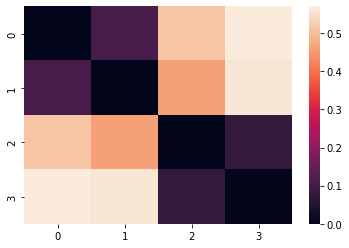

In [49]:
sns.heatmap(data=frame)

plt.show()